XGBoost(eXtra Gradient Boost) 주요 장점
- 뛰어난 예측 성능
- GBM 대비 빠른 수행 시간
  - CPU 병렬 처리, GPU 지원
- 다양한 성능 향상 기능
  - 규제(Regularization) 기능 탑재
  - Tree Pruning (가지치기)
- 다양한 편의 기능
  - 조기 중단(Early Stopping)
  - 자체 내장된 교차 검증
  - 결손값 자체 처리
- 조기 중단 기능 (Early Stopping)
  - 특정 반복 횟수 만큼 더 이상 비용 함수가 감소하지 않으면 지정된 반복횟수를 다 완료하지 않고 수행을 종료할 수 있음
  - 학습을 위한 시간을 단축 시킬 수 있음
  - 반복 횟수를 너무 단축할 경우 예측 성능 최적화가 안된 상태에서 학습이 종료 될 수 있음
  - 주요 파라미터
    - early_stopping_rounds : 더 이상 비용 평가 지표가 감소하지 않는 최대 반복횟수
    - eval_metric : 반복 수행 시 사용하는 비용 평가 지표
    - eval_set : 평가를 수행하는 별도의 검증 데이터 세트. 일반적으로 검증 데이터 세트에서 반복적으로 비용 감소 성능 평가

Python wrapper XGBoost

In [2]:
import xgboost as xgb
from xgboost import plot_importance
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

dataset = load_breast_cancer()
X_features = dataset.data
y_label = dataset.target

cancer_df = pd.DataFrame(data=X_features, columns=dataset.feature_names)
cancer_df['target'] = y_label
cancer_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


In [21]:
print(dataset.target_names)
print(cancer_df['target'].value_counts())

['malignant' 'benign']
1    357
0    212
Name: target, dtype: int64


In [22]:
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size=0.2, random_state=156)
print(X_train.shape, X_test.shape)

(455, 30) (114, 30)


In [0]:
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

In [0]:
params = {
    'max_depth':3, 
    'eta':0.1, # learning rate
    'objective':'binary:logistic', # 결정함수
    'eval_metric':'logloss', # 손실 측정
    'early_stoppings':100 }
num_rounds = 400

In [0]:
# train data set : 'train', evaluation(test) data set : 'eval'
wlist = [(dtrain, 'train'), (dtest, 'eval')]
# 하이퍼 파라미터와 early stopping 파라미터를 train() 함수의 파라미터로 전달
xgb_model = xgb.train(params = params, dtrain=dtrain, num_boost_round=num_rounds, evals=wlist)

In [29]:
pred_probs = xgb_model.predict(dtest)
print('predict() 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨')
print(np.round(pred_probs[:10], 3))

# 예측 확률이 0.5 보다 크면 1, 그렇지 않으면 0으로 예측값 결정하여 List 객체인 preds에 저장
preds = [1 if x > 0.5 else 0 for x in pred_probs]
print('예측값 10개만 표시:', preds[:10])

predict() 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨
[0.95  0.003 0.9   0.086 0.993 1.    1.    0.999 0.998 0.   ]
예측값 10개만 표시: [1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


In [33]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval(y_test, pred):
  confusion = confusion_matrix(y_test, pred)
  accuracy = accuracy_score(y_test, pred)
  precision = precision_score(y_test, pred)
  recall = recall_score(y_test, pred)
  f1 = f1_score(y_test, pred)
  roc_auc = roc_auc_score(y_test, pred)
  print('오차 행렬')
  print(confusion)
  print('정확도 : {0:.4f}, 정밀도 : {1:.4f}, 재현율 : {2:.4f}, F1 : {3:.4f},\
  AUC : {4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

get_clf_eval(y_test, preds)

오차 행렬
[[35  2]
 [ 1 76]]
정확도 : 0.9737, 정밀도 : 0.9744, 재현율 : 0.9870, F1 : 0.9806,  AUC : 0.9665


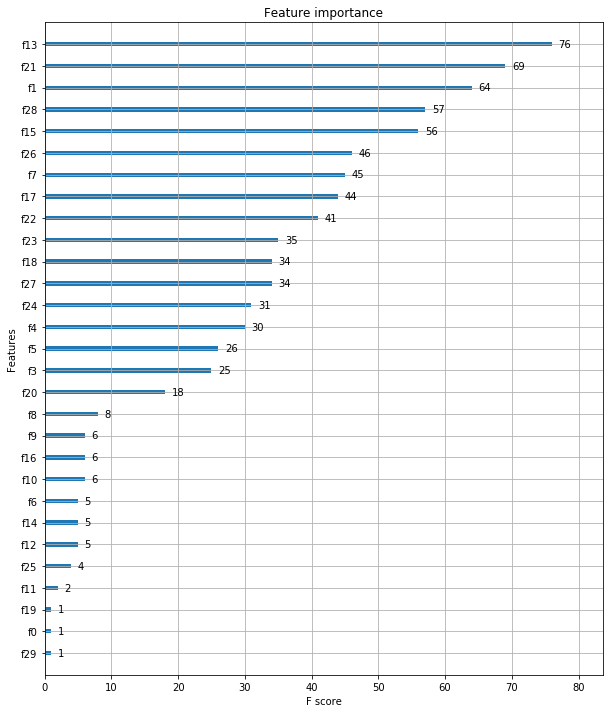

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgb_model, ax=ax)

sklearn Wrapper XGBoost 적용

In [0]:
from xgboost import XGBClassifier

evals = [(X_test, y_test)]
xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds=400, eval_set=evals, eval_metric='logloss', verbose=True)
w_preds = xgb_wrapper.predict(X_test)

In [36]:
get_clf_eval(y_test, w_preds)

오차 행렬
[[35  2]
 [ 1 76]]
정확도 : 0.9737, 정밀도 : 0.9744, 재현율 : 0.9870, F1 : 0.9806,  AUC : 0.9665


In [0]:
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
evals = [(X_test, y_test)]
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_metric='logloss', eval_set=evals, verbose=True)
ws100_preds = xgb_wrapper.predict(X_test)

In [38]:
get_clf_eval(y_test, ws100_preds)

오차 행렬
[[34  3]
 [ 1 76]]
정확도 : 0.9649, 정밀도 : 0.9620, 재현율 : 0.9870, F1 : 0.9744,  AUC : 0.9530


In [0]:
# early_stopping_rounds를 10으로 설정하고 재학습.
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds=10, eval_metric='logloss', eval_set=evals, verbose=True)
ws10_preds = xgb_wrapper.predict(X_test)

get_clf_eval(y_test, ws10_preds)

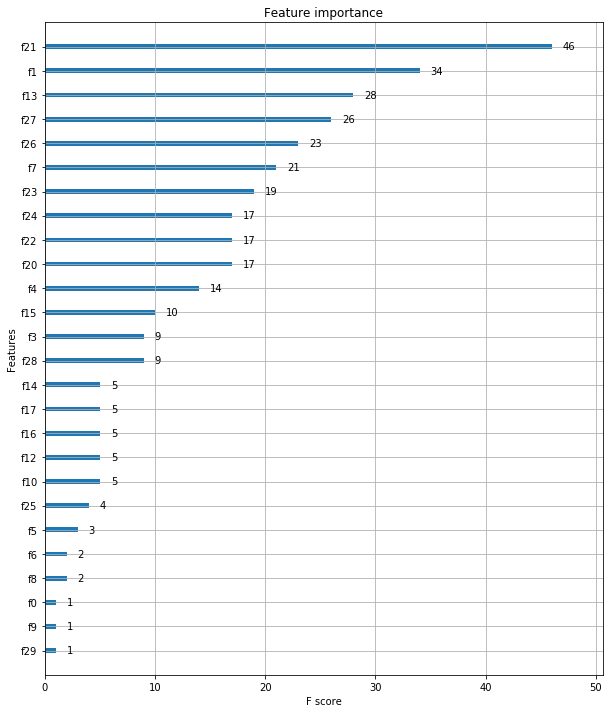

In [42]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgb_wrapper, ax=ax)